In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

Get data

In [42]:
horizontal = []
vertical = []
data_arr = []
for i in range(1,101):
    h = pd.read_csv("OceanFlow/"+str(i)+'u.csv').to_numpy().T
    v = pd.read_csv("OceanFlow/"+str(i)+'v.csv').to_numpy().T
    horizontal.append(h)
    vertical.append(v)
    data_arr.append(np.transpose(np.array([h,v],dtype=np.float32),[1,2,0]))

# merge them to 3D time sliced data
V = np.stack(vertical)
U = np.stack(horizontal)
data = np.array(data_arr)

mask_file = 'OceanFlow/mask.csv'
mask_data = np.loadtxt(mask_file, delimiter=',')

grid_space = 3
print(V.shape, U.shape, data.shape)

(100, 555, 503) (100, 555, 503) (100, 555, 503, 2)


Get the coordinates (in Kilometers) of the point with smallest variation in speed flow:

- calculate the magnitude for each data point, then compute the variance across time
- Some elements do not have meaningful data (all zeros, generally land and the border of the map). Remove any locations with a variance of zero before finding the minimum.
- The answer is in kilometers, as specified above, the zero-indexed element (0,0)  corresponds to (0 km, 0 km). The grid spacing is 3 km. Multiply your zero-indexed indices by 3 to get the location in kilometers.

In [3]:
# speed_flow = magnitude
speed_flow = np.sqrt(np.sum([U**2,V**2], axis=0))
variance = np.var(speed_flow, axis=0,ddof=0).astype(float)

# remove 0 variance
variance[variance==0]=np.nan

# get the min variance
min_var =  np.unravel_index(np.nanargmin(variance, axis=None), variance.shape)
min_var_x,min_var_y = np.multiply(min_var,grid_space)
# add grid space for the vertical flow. 
min_var_y = min_var_y+grid_space
print("Minimum variance in speed flow is {} km in X-axis and {} km in Y-axis".format(min_var_x,min_var_y))

Minimum variance in speed flow is 510 km in X-axis and 363 km in Y-axis


In [4]:
max_var =  np.unravel_index(np.nanargmax(variance, axis=None), variance.shape)
max_var_x,max_var_y = np.multiply(max_var,grid_space)
# add grid space for the y-axis. 
max_var_y = max_var_y+grid_space
print("Maximum variance in speed flow is {} km in X-axis and {} km in Y-axis".format(max_var_x,max_var_y))

Maximum variance in speed flow is 1041 km in X-axis and 543 km in Y-axis


Provide the coordinates (in Kilometers) and the time stamp (in hours), of the point where the flow has its maximum -axis velocity (the maximum signed value).

Something to look out for:

One answer is in hours, as specified above, the zero-indexed element 0 corresponds to 0 hrs. The time spacing is 3 hours. Multiply your zero-indexed time index by 3 to get the location in hours.

In [5]:
max_vel = np.unravel_index(np.nanargmax(U, axis=None), U.shape)
max_vel_hr,max_vel_x, max_vel_y = np.array(max_vel)* grid_space
# add grid space for the y-axis. 
max_vel_y = max_vel_y+grid_space
print("Maximum velocity in horizontal flow in is X-axis = {} km, Y-axis={} km in {} hours ".format(max_vel_x,max_vel_y,max_vel_hr))


Maximum velocity in horizontal flow in is X-axis = 1041 km, Y-axis=543 km in 84 hours 


In [6]:
max_vel = np.unravel_index(np.nanargmax(V, axis=None), V.shape)
max_vel_v_hr,max_vel_v_x, max_vel_v_y = np.array(max_vel)* grid_space
# add grid space for the y-axis. 
max_vel_v_y = max_vel_v_y+grid_space
print("Maximum velocity in vertical flow is X-axis = {} km, Y-axis={} km in {} hours ".format(max_vel_v_x,max_vel_v_y,max_vel_v_hr))

Maximum velocity in vertical flow is X-axis = 1014 km, Y-axis=540 km in 84 hours 


Take the average of the velocity vector over all time and positions, so that you get an overall average velocity for the entire data set.

Note you should average over land positions for this problem, do not attempt to remove them from the average. (You may want to consider in your own time how this might bias the result.)

Please enter the x (horizontal, u files) component of this velocity, in kilometers/hour. Please enter your answer to three significant figures (graded to 1% tolerance).

In [7]:
mu_u = np.mean(U)
print("Average velocity in X-axis is {} KM/hr".format(mu_u))

Average velocity in X-axis is -0.09384849668085234 KM/hr


Please enter the y (vertical, v files) component of this velocity, in kilometers/hour. Please enter your answer to three significant figures (graded to 1% tolerance).

In [8]:
mu_v = np.mean(V)
print("Average velocity in y-axis is {} KM/hr".format(mu_v))

Average velocity in y-axis is -0.03555443189583662 KM/hr


**Identifying long-range correlations.**

In this problem, we will try to identify areas in the Philippine Archipelago with long-range correlations. Your task is to identify two places on the map that are not immediately next to each other but still have some high correlation in their flows. Your response should be the map of the Archipelago with the two areas marked (e.g., circled). You claim that those two areas have correlated flows. Explain how did you found those two areas have correlated flows. Below you will find some hints.

A point is a particular location in the provided data set. Moreover, we have 100  measurements (at 100 different times) of the flow speeds in the x-axis and y-axis for each point. To compute the correlation between two points: select two points and compute the correlation coefficient along the x-direction, or the y-direction, or both. That is a correlation between two vectors of dimension 100.

The provided data set is quite large, with a map of 555 X 504 points. Thus, computing the correlation between every possible pair of points might be computationally expensive. You will need to compute (555*504)**2 = 78243278400 correlations! That is very large. Instead, you can randomly sample pairs of points and compute their correlations.

Since this is a relatively small area, there might be many correlations between the points, so set the threshold to define “high correlations" sufficiently large. If it is too small, you will find that most of the points are correlated. If it is too high, no pairs of points will be correlated.


An area might be a single point correlated with other points. However, maybe there are clusters of points that are correlated with other clusters of points.

Remember that correlation can be positive or negative. You are free to select whether you want to find positively correlated areas or negatively correlated areas.

You are suggested to find a correlation for each direction separately. You are free to select how to combine these two values. Maybe set the correlation between the two points as the maximum directional correlation. Average between the two directional correlations also work. Of course, the minimum as well.

In [59]:
def distance(point1, point2): # point1 = [y1,x1], point2 = [y2,x2]
    y1, x1 = point1[0], point1[1]
    y2, x2 = point2[0], point2[1]
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

N_Pairs = 10**4
# set the horizontal variance to null if the value is 0
u_var = np.var(U, axis=0,ddof=0).astype(float)
new_horz = U.copy()
for i in range(U.shape[0]):
    new_horz[i][u_var==0] = np.nan

# Create Random pairs
pairs = np.array([  np.random.randint(0, U.shape[1], size=[2, N_Pairs]), 
                    np.random.randint(0, V.shape[2], size=[2, N_Pairs]) 
                 ]).transpose([2, 1, 0])
print("random pairs = ", len(pairs))

# Get the correlations between the pairs
correlations = {}
for i in range(len(pairs)):
    x1,y1 = list(pairs[i][0])
    x2,y2 = list(pairs[i][1])
    _coeff =  np.corrcoef(new_horz[:,x1,y1], new_horz[:, x2,y2])
    correlations[((x1,y1),(x2,y2))] = _coeff
clean_corr = {}
for k in correlations:
    if not np.isnan(correlations[k][0,1]) and correlations[k][0,1]!=1:
        clean_corr[k] = correlations[k]

sort_corr = sorted(clean_corr.items(), key=lambda x: x[1][0,1], reverse=True) # sort in descending
# sort_corr

random pairs =  10000


In [61]:
threshold_pos = 0.96
threshold_neg = -0.96

lr_pos = []
lr_neg = []
for cor in sort_corr:
    if distance(cor[0][0],cor[0][1]) > 50:
        if cor[1][0,1] > threshold_pos:
            lr_pos.append([cor[0], cor[1][0,1]])
        elif cor[1][0,1] < threshold_neg:
            lr_neg.append([cor[0], cor[1][0,1]])

C:\Users\z003twmx\AppData\Local\Temp\ipykernel_17492\3186051643.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot([lr_pos[i][0][0][1], lr_pos[i][0][1][1]], [lr_pos[i][0][0][0], lr_pos[i][0][1][0]], 'ro-', color=colors_pos[i])
C:\Users\z003twmx\AppData\Local\Temp\ipykernel_17492\3186051643.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot([lr_neg[i][0][0][1], lr_neg[i][0][1][1]], [lr_neg[i][0][0][0], lr_neg[i][0][1][0]], 'ro-', color=colors_neg[i])


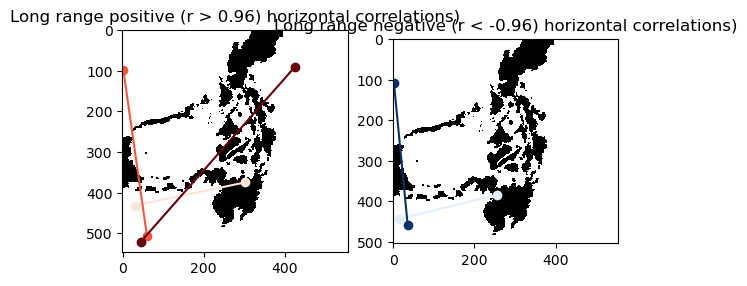

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2)
# Positive horizontal correlations
#ax1 = sns.heatmap(mask_data, cbar=False)
ax1.imshow(mask_data, cmap='binary_r', interpolation='nearest')
colors_pos = [ cm.Reds(x) for x in np.linspace(0.1, 1, len(lr_pos)) ]
for i in range(0, len(lr_pos)):
    ax1.plot([lr_pos[i][0][0][1], lr_pos[i][0][1][1]], [lr_pos[i][0][0][0], lr_pos[i][0][1][0]], 'ro-', color=colors_pos[i])

ax1.set_title(f"Long range positive (r > {threshold_pos}) horizontal correlations)")
ax1.grid(False)
# Negative horizontal correlations
ax2.imshow(mask_data, cmap='binary_r', interpolation='nearest')
colors_neg = [ cm.Blues(x) for x in np.linspace(0.1, 1, len(lr_neg)) ]
for i in range(0, len(lr_neg)):
    ax2.plot([lr_neg[i][0][0][1], lr_neg[i][0][1][1]], [lr_neg[i][0][0][0], lr_neg[i][0][1][0]], 'ro-', color=colors_neg[i])

ax2.set_title(f"Long range negative (r < {threshold_neg}) horizontal correlations)")
ax2.grid(False)
plt.show()


In [ ]:
# Helper function to round location to integer point and snap it to the grid if it goes out of bounds
def clip(location):
    _, y_lim, x_lim = U.shape
    _loc=location
    if location[0] < 0: # negative case
        _loc[0] = 0 
    elif location[0] > y_lim-1: # positive case
        _loc[0] = y_lim-1

    if location[1] < 0: # negative case
        _loc[1] = 0 
    elif location[1] > x_lim-1: # positive case
        _loc[1] = x_lim-1

    return _loc

def euclidean_distance(point1,point2):
    y1,x1 = point1
    y2,x2=point2
    return np.sqrt((x2-x1)**2 +(y2-y2)**2)

def velocity(location, time):
    if location # out of bounds:
        location = #argmin of euclidean distance serrogate loc
    v = # function of loc and t
    return v

In [ ]:
# threashold for high correlations
cor_thresh = 1000

random_mean = [300, 250]
random_var = 100
random_cov = [[100, 0], [0, 100]]  # diagonal covariance
sample_size = 50000
# random samples
rand_y,rand_x = np.random.default_rng().multivariate_normal(random_mean, random_cov, sample_size).T  # Draw random samples from a multivariate normal distribution.

# start simulation
total_time = 100
grid_size= 3
Time = total_time // 3  # 3 dimension space
measurement_times = 100
epsilon = 3
# get the land and water points from the random sample size
rand_points =[]
land_points = []
for i in range(sample_size):
    _y = rand_y[i]
    _x = rand_x[i]
    if mask_data[int(np.round(_y)),int(np.round(_x))]:
        rand_points.append(np.array([float(_y),float(_x)]))
    else:
        land_points.append(np.array([float(_y),float(_x)]))


speed_flow = np.sqrt(np.sum([U**2,V**2], axis=0))
print(speed_flow.shape)
print(np.array(rand_points).shape)
print(np.array(land_points).shape)


In [ ]:
# Color Map
colors = [ cm.viridis(x) for x in np.linspace(0, 1, len(rand_points)) ]
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(mask_data.T, origin='lower', cmap='binary_r', interpolation='nearest')

for t in range(measurement_times):
    sample_speed_flow = []
    for i in range(len(rand_points)):
        loc = tuple(map(int,np.round(rand_points[i])))
        sample_speed_flow.append(speed_flow[t][loc])
        # epsilon/grid_size is 1 in this case
        _x = U[t][loc]
        _y = V[t][loc]
        rand_points[i] = rand_points[i] + np.array([_x,_y])
        rand_points[i] = clip(rand_points[i])

    # Plotting simulation
    _alpha = (t**2/measurement_times**2)+0.1
    if _alpha>1:
        _alpha =1
    elif _alpha<0:
        _alpha =0.1
    dot_size = np.multiply(50,sample_speed_flow)
    plt.scatter(*zip(*rand_points), s=dot_size, c=colors, alpha=_alpha)
plt.show()

In [ ]:
U.shape

In [ ]:
num_pairs = 50000
dist_threshold = 1500
pairs = np.array([  np.random.randint(0, U.shape[1], size=[2, num_pairs]), 
                    np.random.randint(0, V.shape[2], size=[2, num_pairs]) 
                 ]).transpose([2, 1, 0])
idx_dist_threshold = dist_threshold/3.0
# pairs_dists = np.sqrt(np.square(pairs[:,0,:] - pairs[:, 1, :]).sum(axis=1))
print(len(pairs))
pairs_dists = [euclidean_distance(pairs[i,0,:],pairs[i,1,:]) for i in range(len(pairs))]
random_pairs = []
for i in range(len(pairs)):
   _dist = euclidean_distance(pairs[i,0,:],pairs[i,1,:])
   if _dist>idx_dist_threshold:
      random_pairs.append(pairs[i,:,:])
# random_pairs = pairs[pairs_dists > idx_dist_threshold, :, :]

np.array(random_pairs).shape

In [ ]:
x = [[1,2,3],[2,3,4],[3,4,5]]
y = [[4,5,6],[5,6,7],[6,7,8]]
np.stack([x,y]).shape